Home Budget
-----

In [1]:
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from google_auth_oauthlib import flow
from apiclient.discovery import build

import config.settings as settings

SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"]
URL = 'https://sheets.googleapis.com/v4/spreadsheets/' + settings.SPREADSHEET_ID

def parse_google_auth(file):
  """
  parse_goole_auth(file)
  :param: file is a String with a path (relative or absolute) to the given JSON file.

  This function requires a JSON file for a specific Google OAuth user.
  This can be received from the Google Cloud Console for the linked project.
  """
  log("Loading Google Sheet... ", end="")
  try:
    saved_token = open('config/token.bin', 'rb')
    creds = pickle.load(saved_token)
    log("Saved token found")
  except FileNotFoundError:
    saved_token = open('config/token.bin', 'wb+')
    auth_flow = flow.InstalledAppFlow.from_client_secrets_file(file, scopes=SCOPES)
    creds = auth_flow.run_local_server(open_browser=True)
    pickle.dump(creds, saved_token)
    log("New token saved")
  finally:
    saved_token.close()

  service = build('sheets', 'v4', credentials=creds)
  return service

def get_sheet_values(file_id=settings.SPREADSHEET_ID):
  service = parse_google_auth("config/oauth2.json")
  log("Getting sheet values:")
  return_values = {}
  for range_string in settings.SHEET_NAMES:
    log("\t {}... ".format(range_string), end="")
    request = service.spreadsheets().values().batchGet(
        spreadsheetId=settings.SPREADSHEET_ID, ranges=range_string)
    response = request.execute()
    values = response['valueRanges'][0]['values']
    return_values[range_string] = values
    log("done")
  return return_values

def log(string, end='\n'):
    '''
    For backwards compatibility
    '''
    print(string)
    
vals = get_sheet_values()

Loading Google Sheet... 
Saved token found
Getting sheet values:
	 Transactions... 
done
	 Categories... 
done
	 Balance History... 
done


In [2]:
plt.style.use('seaborn')

In [160]:
bal_hist = pd.DataFrame(vals['Balance History'][1:], columns=vals['Balance History'][0][:-1])
bal_hist.set_index(pd.to_datetime(bal_hist.pop('Date') + ' ' + bal_hist.pop('Time')), inplace=True)
bal_hist['Balance'] = pd.to_numeric(bal_hist['Balance'].str.replace('$', '').str.replace(',', ''))
small_hist = bal_hist.loc[:, ['Balance', 'Class']].loc[:'1971-01-01']
liabilities = small_hist[small_hist['Class'] == 'Liability']
assets = small_hist[small_hist['Class'] == 'Asset']
liabilities.loc[:, 'Balance'] *= -1

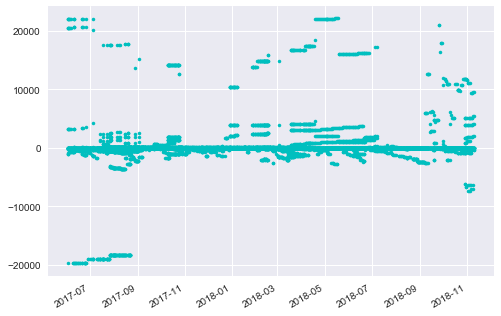

In [274]:
new_hist = pd.concat([liabilities['Balance'], assets['Balance']])
new_hist = new_hist.sort_index()
new_hist = new_hist[new_hist < 25000]
# new_hist.describe()
new_hist.plot(style='c.')
# new_hist_ave = new_hist.rolling(window=30).median()
# new_hist_ave.plot(style='k-')